# Data-Driven Proposals with PyTorch

This tutorial is a short extension to [Data-Driven Proposals in Gen](../Data-Driven%20Proposals%20in%20Gen.jl), 
which shows how to use PyTorch for easier specification of the proposal.

For this tutorial, you'll need to ensure that you have PyCall, GenPyTorch installed, and pointing to a Python that has pytorch installed.

1. In your Python environment, install pytorch:

See instructions here: https://pytorch.org/


2. You need to build PyCall again in your current Julia environment after you install pytorch in your python environment and then restart Julia, so that PyCall can import the pytorch installed in your python environment.


`Pkg.add("PyCall")`

`ENV["PYTHON"] = [PATH TO YOUR PYTHON EXECUTABLE]`

`Pkg.build("PyCall")`

Then restart Julia


3. Install GenPyTorch:

`Pkg.add(https://github.com/probcomp/GenPyTorch.jl.git)`


In [1]:
using Gen, GenPyTorch, PyCall

We recreate the relevant parts of the model from the Data-Driven Proposals in Gen tutorial:

In [2]:
include("./inverse-planning/geometric_primitives.jl");
include("./inverse-planning/scene.jl");
include("./inverse-planning/viz.jl")
include("./inverse-planning/planning.jl");

scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(rrt_iters=600, rrt_dt=0.05,
                               refine_iters=3500, refine_std=1.);

@gen function agent_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


PyCall allows us to import Python libraries directly into our Julia code:

In [3]:
torch = pyimport("torch")
nn = torch.nn
F = nn.functional

PyObject <module 'torch.nn.functional' from '/Users/tianminshu/anaconda3/envs/CogAI/lib/python3.7/site-packages/torch/nn/functional.py'>

It also provides the `@pydef` macro, which we can use to define Python classes using Julia code.
In PyTorch, new neural network architectures are defined as subclasses
of the `nn.Module` class. We create our own neural network class here, 
called `NeuralProposal`. 

Every module needs to define two methods: `__init__` and `forward`.

In `__init__`, we create any layers we will use later. The expression 
`nn.Linear(input_dim, output_dim)` creates a fully-connected layer mapping
a given number of input dimensions to a given number of output dimensions.
Here, we construct three such layers: `fc1` maps our four inputs to 50 hidden
units, `fc2` transforms the 50 hidden units, and `fc3` maps the 50 hidden
units to 5 output neurons, which will later be normalized into the 5
bin probabilities for `dest_x` or `dest_y`. (PyTorch also comes with helpers
for constructing more complex layers, including convolutional layers and RNN
cells, but we do not cover that here.)

The `forward` function actually implements the neural network's computation,
making use of any layers created in `__init__`. Here, we use `ReLU` activation
functions, instead of the `tanh`-based activation used in the previous section.

In [4]:
@pydef mutable struct NeuralProposal <: nn.Module
    function __init__(self, num_in)
        # Note the use of pybuiltin(:super): built in Python functions
        # like `super` or `str` or `slice` are all accessed using
        # `pybuiltin`.
        pybuiltin(:super)(NeuralProposal, self).__init__()
        self.fc1 = nn.Linear(num_in, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 5)
    end

    function forward(self, x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    end
end

PyObject <class 'NeuralProposal'>

Once we've defined a `nn.Module`, we can create a generative function out of it
using the `TorchGenerativeFunction` constructor. The first argument is an
instantiated Torch model, in our case, `NeuralProposal(4)`. Here, `4` is the
value we are passing into `NeuralProposal`'s `__init__` method, which expects
us to provide `num_in`, the number of input units. The second argument to
`TorchGenerativeFunction` is a list of `TorchArg` objects, describing the 
arguments to the `forward` function. We have only one argument, `x`, so we pass
in a list of one element. A `TorchArg` object specifies the argument's `dtype` 
(`torch.float` in this case, for 32-bit floating-point numbers), and a Boolean
for whether gradients should flow through this argument (almost always `true`, unless
the argument is some discrete value, e.g., a Boolean flag). Finally, we pass in
the number of output tensors to expect from calling `forward` -- in this case, just one.

In [5]:
x_nn = TorchGenerativeFunction(NeuralProposal(4), [TorchArg(true, torch.float)], 1);

`x_nn` can now be called on inputs:

In [6]:
x_nn([0.0, 0.0, 0.0, 0.0])

5-element Vector{Float64}:
 -0.1864721179008484
  0.014883525669574738
  0.14345356822013855
 -0.048308514058589935
 -0.03395839035511017

To turn these into bin probabilities, we'll use `softmax`:

In [7]:
softmax(logits) = exp.(logits .- logsumexp(logits))

softmax(x_nn([0.0, 0.0, 0.0, 0.0]))

5-element Vector{Float64}:
 0.16872379606281537
 0.20635926996116846
 0.23467198280345078
 0.19372248377976933
 0.19652246739279608

Our proposal in this section will actually use _two_ neural networks: after 
generating a `dest_x` using the probabilities from `x_nn`, it will generate
a `dest_y` from a second network, `y_nn`. But `y_nn` will take an additional
argument: the sampled `dest_x` value. This way, in theory, the `y` neural network
can propose different `dest_y` values depending on the sampled `x`.

To this end, we create a `y_nn` that accepts 5 inputs, rather than 4. Note that
every time we call `NeuralProposal(...)`, it is calling `__init__` to generate a
fresh set of layers and their parameters; so the parameters are not shared between
`x_nn` and `y_nn`.

In [8]:
y_nn = TorchGenerativeFunction(NeuralProposal(5), [TorchArg(true, torch.float)], 1);

We are now ready to write our custom proposal, which calls each neural 
network to generate probabilities, then samples using `piecewise_uniform`.
Note that because the neural networks are generative functions, we call them
using `~` --- even though they make no random choices. This is important for
Gen's gradient-based optimization features to work properly.

In [9]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5
num_x_bins = 5
num_y_bins = 5;

@gen function custom_dest_proposal_torch(measurements::Vector{Point}, scene::Scene)
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs ~ x_nn([x_first, y_first, x_last, y_last])
    dest_x ~ piecewise_uniform(x_bounds, softmax(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    y_probs ~ y_nn([x_first, y_first, x_last, y_last, dest_x])
    
    dest_y ~ piecewise_uniform(y_bounds, softmax(y_probs))
    
    return nothing
end;

To train the proposal, we construct an update that applies a fixed step size gradient descent move. We indicate that we want the update to apply to all the trainable parameters of `x_nn` and all the trainable parameters of `y_nn`. Note that `custom_dest_proposal_torch` does not have any trainable parameters of its own, unlike `custom_dest_proposal_neural`.

In [10]:
update = Gen.ParamUpdate(Gen.ADAM(0.001, 0.9, 0.999, 1e-8), 
    x_nn => collect(get_params(x_nn)), y_nn => collect(get_params(y_nn)));

And run the training procedure. Here, we've used the more effective ADAM
optimizer, so we can get by with less training. (But more training
may still help, and you may decide to run it for more epochs or larger epochs!
If you have a GPU available, GenPyTorch should automatically use it.)

In [11]:
function data_generator()
    
    # since these names are used in the global scope, explicitly declare it
    # local to avoid overwriting the global variable
    local measurements
    local choices
    
    # obtain an execution of the model where planning succeeded
    done = false
    while !done
        (choices, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
        (planning_failed, maybe_path) = retval       
        done = !planning_failed
    end

    # construct arguments to the proposal function being trained
    measurements = [Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    # construct constraints for the proposal function being trained
    constraints = Gen.choicemap()
    constraints[:dest_x] = choices[:dest_x]
    constraints[:dest_y] = choices[:dest_y]
    
    return (inputs, constraints)
end;

In [12]:
Gen.train!(custom_dest_proposal_torch, data_generator, update,
    num_epoch=200, epoch_size=100, num_minibatch=1, minibatch_size=100,
    evaluation_size=10, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 1 minibatches of size 100...
epoch 1: evaluating on 10 examples...
epoch 1: est. objective value: -0.008359983892640232
epoch 2: generating 100 training examples...
epoch 2: training using 1 minibatches of size 100...
epoch 2: evaluating on 10 examples...
epoch 2: est. objective value: 0.06477854642463103
epoch 3: generating 100 training examples...
epoch 3: training using 1 minibatches of size 100...
epoch 3: evaluating on 10 examples...
epoch 3: est. objective value: 0.0008274613917347961
epoch 4: generating 100 training examples...
epoch 4: training using 1 minibatches of size 100...
epoch 4: evaluating on 10 examples...
epoch 4: est. objective value: -0.01214499761564789
epoch 5: generating 100 training examples...
epoch 5: training using 1 minibatches of size 100...
epoch 5: evaluating on 10 examples...
epoch 5: est. objective value: -0.00599684125784099
epoch 6: generating 100 training examples...
epoch 6: train

epoch 44: training using 1 minibatches of size 100...
epoch 44: evaluating on 10 examples...
epoch 44: est. objective value: 0.05076251181913864
epoch 45: generating 100 training examples...
epoch 45: training using 1 minibatches of size 100...
epoch 45: evaluating on 10 examples...
epoch 45: est. objective value: 0.12046696459291614
epoch 46: generating 100 training examples...
epoch 46: training using 1 minibatches of size 100...
epoch 46: evaluating on 10 examples...
epoch 46: est. objective value: 0.06451627134186136
epoch 47: generating 100 training examples...
epoch 47: training using 1 minibatches of size 100...
epoch 47: evaluating on 10 examples...
epoch 47: est. objective value: 0.15129470090461034
epoch 48: generating 100 training examples...
epoch 48: training using 1 minibatches of size 100...
epoch 48: evaluating on 10 examples...
epoch 48: est. objective value: 0.12996341172843068
epoch 49: generating 100 training examples...
epoch 49: training using 1 minibatches of siz

epoch 87: training using 1 minibatches of size 100...
epoch 87: evaluating on 10 examples...
epoch 87: est. objective value: 0.33253117629215145
epoch 88: generating 100 training examples...
epoch 88: training using 1 minibatches of size 100...
epoch 88: evaluating on 10 examples...
epoch 88: est. objective value: 0.4860349637153839
epoch 89: generating 100 training examples...
epoch 89: training using 1 minibatches of size 100...
epoch 89: evaluating on 10 examples...
epoch 89: est. objective value: 0.44724242816677273
epoch 90: generating 100 training examples...
epoch 90: training using 1 minibatches of size 100...
epoch 90: evaluating on 10 examples...
epoch 90: est. objective value: 0.42013135902113063
epoch 91: generating 100 training examples...
epoch 91: training using 1 minibatches of size 100...
epoch 91: evaluating on 10 examples...
epoch 91: est. objective value: 0.4898171795233889
epoch 92: generating 100 training examples...
epoch 92: training using 1 minibatches of size 

epoch 130: training using 1 minibatches of size 100...
epoch 130: evaluating on 10 examples...
epoch 130: est. objective value: 0.5621884078635422
epoch 131: generating 100 training examples...
epoch 131: training using 1 minibatches of size 100...
epoch 131: evaluating on 10 examples...
epoch 131: est. objective value: 0.8731228097838304
epoch 132: generating 100 training examples...
epoch 132: training using 1 minibatches of size 100...
epoch 132: evaluating on 10 examples...
epoch 132: est. objective value: 0.814388724800718
epoch 133: generating 100 training examples...
epoch 133: training using 1 minibatches of size 100...
epoch 133: evaluating on 10 examples...
epoch 133: est. objective value: 0.37413108087997315
epoch 134: generating 100 training examples...
epoch 134: training using 1 minibatches of size 100...
epoch 134: evaluating on 10 examples...
epoch 134: est. objective value: 0.544958161342991
epoch 135: generating 100 training examples...
epoch 135: training using 1 min

epoch 172: evaluating on 10 examples...
epoch 172: est. objective value: 0.8435946339435028
epoch 173: generating 100 training examples...
epoch 173: training using 1 minibatches of size 100...
epoch 173: evaluating on 10 examples...
epoch 173: est. objective value: 0.9559127309741978
epoch 174: generating 100 training examples...
epoch 174: training using 1 minibatches of size 100...
epoch 174: evaluating on 10 examples...
epoch 174: est. objective value: 0.6249625803259509
epoch 175: generating 100 training examples...
epoch 175: training using 1 minibatches of size 100...
epoch 175: evaluating on 10 examples...
epoch 175: est. objective value: 0.5981618764767617
epoch 176: generating 100 training examples...
epoch 176: training using 1 minibatches of size 100...
epoch 176: evaluating on 10 examples...
epoch 176: est. objective value: 0.7480430656418962
epoch 177: generating 100 training examples...
epoch 177: training using 1 minibatches of size 100...
epoch 177: evaluating on 10 ex

We can visualize the proposal and see that although it's not perfect, it correctly
focuses on the upper left regions of the scene. 

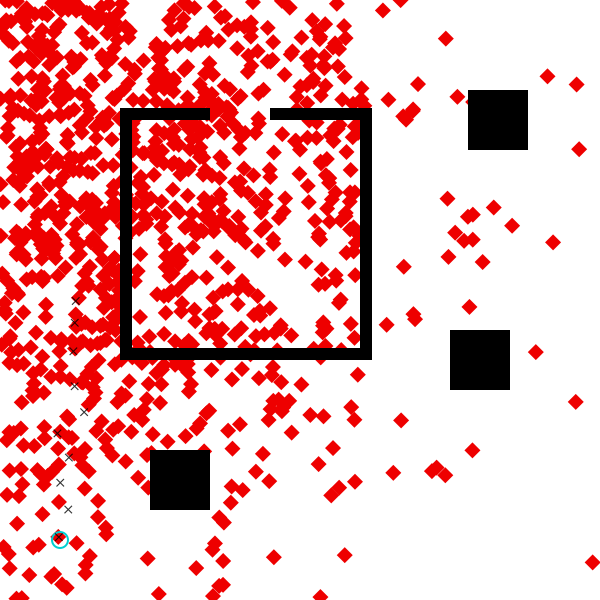

In [13]:
function visualize_custom_destination_proposal(measurements, start, dest_proposal; num_samples=100)
    visualize() do 
        for i=1:num_samples
            (proposed_choices, _) = Gen.propose(dest_proposal, (measurements, scene))
            constraints = choicemap(proposed_choices)
            constraints[:start_x] = start.x
            constraints[:start_y] = start.y
            (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
            draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
        end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_torch, num_samples=1000)

In [14]:
function do_inference_data_driven(
        dest_proposal::GenerativeFunction,
        scene::Scene, dt::Float64,
        num_ticks::Int, planner_params::PlannerParams,
        start::Point, measurements::Vector{Point}, 
        amount_of_computation::Int)
    
    observations = Gen.choicemap((:start_x, start.x), (:start_y, start.y))
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    (trace, _) = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params), 
                    observations, dest_proposal, (measurements, scene), amount_of_computation)
    
    return trace
end;

function visualize_data_driven_inference(measurements, scene, start, proposal; amt_computation=50, samples=1000)
    visualize() do 
      for i=1:samples
          trace = do_inference_data_driven(proposal, 
              scene, dt, num_ticks, planner_params, start, measurements, amt_computation)
          draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
      end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;

Now let's gradually increase the amount of compute for the inference. 

First, let's see "amt_computation=5"

  8.876055 seconds (6.25 M allocations: 377.069 MiB, 0.97% gc time, 2.79% compilation time)


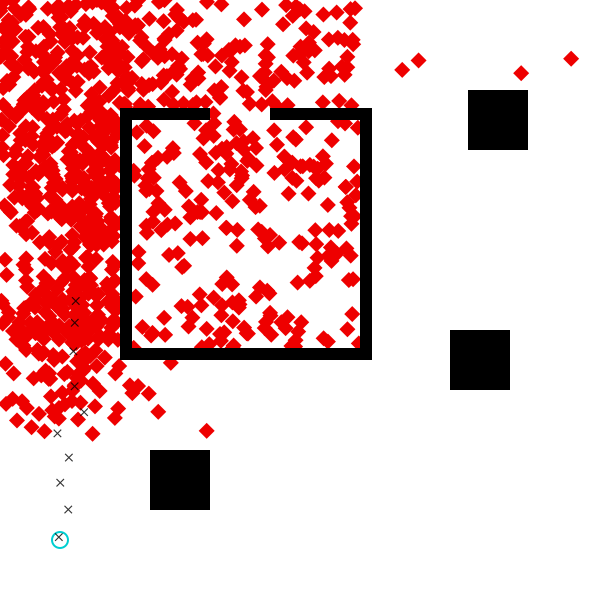

In [15]:
@time visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_torch; amt_computation=5, samples=1000)

Now amt_computation=10

 15.721470 seconds (12.17 M allocations: 733.134 MiB, 0.98% gc time)


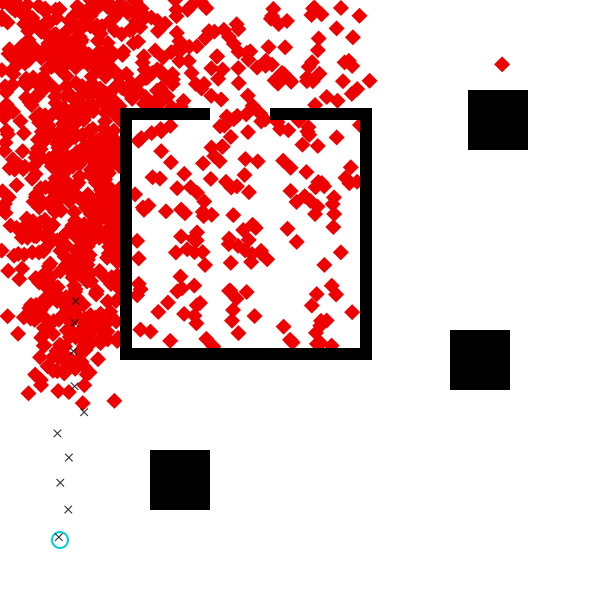

In [16]:
@time visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_torch; amt_computation=10, samples=1000)

 81.390311 seconds (60.44 M allocations: 3.558 GiB, 1.06% gc time)


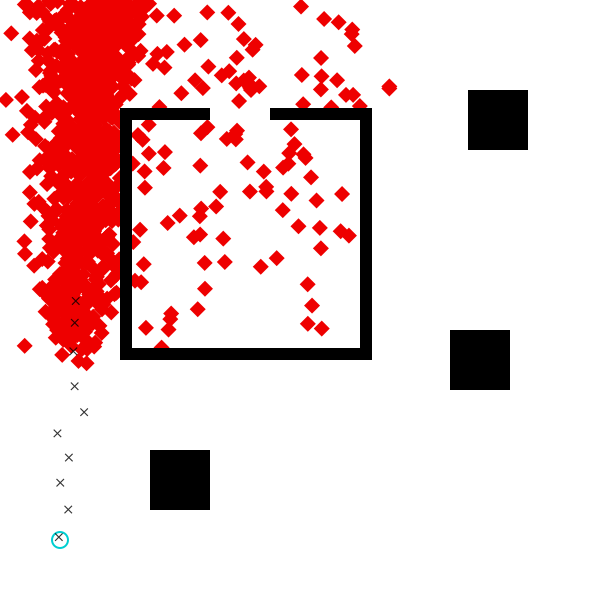

In [17]:
@time visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_torch; amt_computation=50, samples=1000)

Now amt_computation=100

162.728845 seconds (120.76 M allocations: 7.110 GiB, 1.05% gc time)


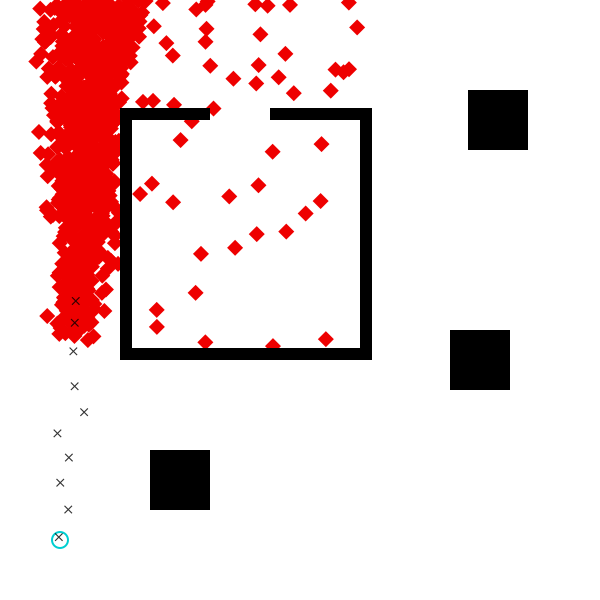

In [19]:
@time visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_torch; amt_computation=100, samples=1000)